Following [an autoencoder tutorial](https://towardsdatascience.com/understanding-autoencoders-with-an-example-a-step-by-step-tutorial-693c3a4e9836).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torch.utils.data import TensorDataset, DataLoader


In [2]:
def draw_circle(r: float, cx: float = 0.5, cy: float = 0.5, size: int = 28):
    """Draw a circle """
    circle = plt.Circle((cx, cy), r, color='k', fill=False)
    fig, ax = plt.subplots(figsize=(1,1))
    ax.add_patch(circle)
    ax.axis('off')
    buf = fig.canvas.print_to_buffer()
    plt.close() # don't plot
    # convert plt.figure into PIL image; grayscale and resize
    return np.array(Image.frombuffer('RGBA', buf[1], buf[0]).convert('L').resize((int(size), int(size))))

In [11]:

def gen_circles(n, size=28):
    cx = np.random.uniform(0.0, 0.03, size=n).reshape(-1, 1) + 0.5
    cy = np.random.uniform(0.0, 0.03, size=n).reshape(-1, 1) + 0.5
    r = np.random.uniform(0.03, 0.47, size=n).reshape(-1, 1)
    sizes = np.ones((n, 1)) * size

    coords = np.concatenate([r, cx, cy, sizes], axis=1)

    circles = np.apply_along_axis(
        func1d=lambda v: draw_circle(*v), # function to apply
        arr=coords, # array to apply it to
        axis=1, # axis along which to apply it
        )

    return circles, r

In [12]:
np.random.seed(42)

# generate 1,000 circles
circles, radii = gen_circles(1000)

In [13]:
# create TensorDataset
circles_ds = torch.utils.data.TensorDataset(
    torch.as_tensor(circles)
    .unsqueeze(1)   # add channels dimension
    .float()/255, # normalize
    torch.as_tensor(radii),
)

# create DataLoader to load in batches
circles_dl = torch.utils.data.DataLoader(
    dataset=circles_ds,
    batch_size=32,
    drop_last=True,
)

In [26]:
def figure1(dataset):
    real = dataset.tensors[0][:10].numpy()
    real = np.rollaxis(real, 1, 4)

    fig, axs = plt.subplots(2, 5, figsize=(10, 4))
    axs = axs.flatten()
    for i in range(10):
        axs[i].set_title(f"Image #{i}")
        axs[i].imshow(real[i].squeeze(), cmap='gray', vmin=0, vmax=1)
    fig.tight_layout()
    return fig

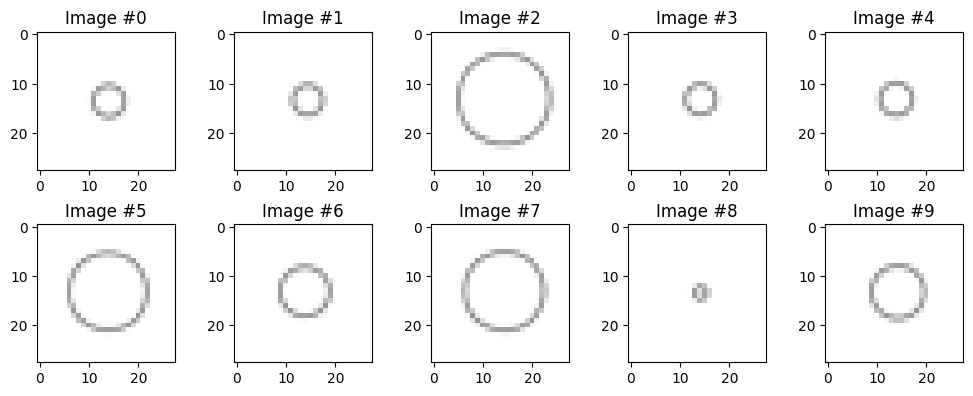

In [27]:
fig = figure1(circles_ds)

In [14]:

def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    np.random.seed(seed)



In [28]:
class Encoder(torch.nn.Module):
    def __init__(self, input_shape, z_size, base_model):
        super().__init__()
        self.input_shape = input_shape
        self.z_size = z_size
        self.base_model = base_model
        # map base model outputs to the desired representation size (linearly)
        output_size = self._get_output_size() # output size of base model
        self.linear_latent = torch.nn.Linear(output_size, z_size)

    def _get_output_size(self):
        """Get the output size of the base model by passing a dummy input
        forward through the base model."""
        device = next(self.base_model.parameters()).device.type # ?
        dummy = torch.zeros(1, *self.input_shape, device=device)
        size = self.base_model(dummy).size(1)
        return size

    def forward(self, x):
        """Forward pass."""
        base_out = self.base_model(x)
        out = self.linear_latent(base_out)
        return out

In [29]:
set_seed(13)

z_size = 1  # latent space dim
input_shape = (1, 28, 28) # (channels, h, w)

base_model = torch.nn.Sequential(
    torch.nn.Flatten(), # flatten input image
    torch.nn.Linear(np.prod(input_shape), 2048),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(2048, 2048),
    torch.nn.LeakyReLU(),
)

encoder = Encoder(input_shape, z_size, base_model)


In [31]:
encoder

Encoder(
  (base_model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=2048, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (linear_latent): Linear(in_features=2048, out_features=1, bias=True)
)

In [32]:
x, _ = circles_ds[7] # test input
z = encoder(x)      # compressed representation
z


tensor([[-0.1209]], grad_fn=<AddmmBackward0>)

In [33]:
decoder = torch.nn.Sequential(
    torch.nn.Linear(z_size, 2048), # z_size -> 2048
    torch.nn.LeakyReLU(),
    torch.nn.Linear(2048, 2048), # 2048 -> 2048
    torch.nn.LeakyReLU(),
    torch.nn.Linear(2048, np.prod(input_shape)), # 2048 -> input_shape
    torch.nn.Unflatten(1, input_shape), # (batch, channels, w, h)
)
decoder

Sequential(
  (0): Linear(in_features=1, out_features=2048, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=2048, out_features=2048, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=2048, out_features=784, bias=True)
  (5): Unflatten(dim=1, unflattened_size=(1, 28, 28))
)

In [34]:
x_tilde = decoder(z) # reconstruction

In [35]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, encoder: Encoder, decoder: torch.nn.Module):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        """Forward pass through the autoencoder."""
        z = self.encoder(x)
        return self.decoder(z)

In [36]:
model_ae = AutoEncoder(encoder, decoder)
model_ae

AutoEncoder(
  (encoder): Encoder(
    (base_model): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=2048, bias=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=2048, out_features=2048, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
    )
    (linear_latent): Linear(in_features=2048, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=2048, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=2048, out_features=784, bias=True)
    (5): Unflatten(dim=1, unflattened_size=(1, 28, 28))
  )
)

In [37]:
set_seed(13)

# move tensors to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_ae.to(device)

loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(model_ae.parameters(), 0.0003) # register params with optimizer

num_epochs = 10
train_losses = []

for epoch in range(1, num_epochs+1):
    batch_losses = [] # store batch losses for this epoch

    for i, (x, _) in enumerate(circles_dl): # iter over batches
        model_ae.train() # tell model we are training
        x = x.to(device)

        # Forward pass
        y_hat = model_ae(x)

        # Calc loss
        loss = loss_fn(y_hat, x)

        # backprop
        loss.backward()
        optim.step()
        optim.zero_grad()

        # record
        batch_losses.append(np.array([loss.data.item()]))
    
    # Average the batch losses for this epoch
    train_losses.append(np.array(batch_losses).mean(axis=0))

    print(f"Epoch {epoch:03d} | Loss >> {train_losses[-1][0]:.4f}")



Epoch 001 | Loss >> 0.1383
Epoch 002 | Loss >> 0.0061
Epoch 003 | Loss >> 0.0048
Epoch 004 | Loss >> 0.0048
Epoch 005 | Loss >> 0.0048
Epoch 006 | Loss >> 0.0048
Epoch 007 | Loss >> 0.0047
Epoch 008 | Loss >> 0.0047
Epoch 009 | Loss >> 0.0045
Epoch 010 | Loss >> 0.0043


In [38]:

def show(tensor, ax=None):
    img = np.rollaxis(tensor.detach().cpu().numpy(), 0, 3)
    kwargs = {'cmap': 'gray', 'vmin': 0, 'vmax': 1} if img.shape[-1] == 1 else {}
    if ax is None:
        plt.imshow(img.squeeze(), **kwargs)
    else:
        ax.imshow(img.squeeze(), **kwargs)

def set_fontsize(ax, size):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(size)

def figure2(autoencoder: AutoEncoder, image, device):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # plot original image
    show(image, ax=axs[0])

    z = autoencoder.encoder(image.to(device)) # forward pass
    x_tilde = autoencoder.decoder(z)[0]
    show(x_tilde, ax=axs[2]) # plot reconstruction

    axs[0].set_title('Original')
    axs[1].axis('off')
    axs[1].annotate(f"z = [{z.item():.4f}]", (0.25, 0.5), fontsize=20)
    axs[1].set_title("Latent Space")
    axs[2].set_title("Reconstruction")
    for i in range(3):
        set_fontsize(axs[i], 20)
    return fig

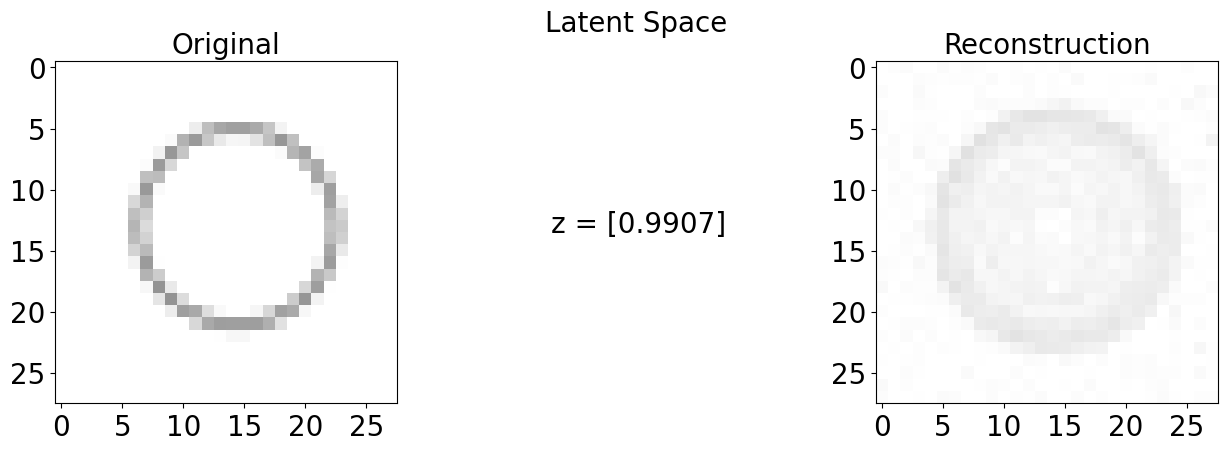

In [43]:
t_idx = 7
x = circles_ds[t_idx][0]

fig = figure2(model_ae, x, "cpu")

In [40]:
def figure4(autoencoder, device):
    fig, axs = plt.subplots(1, 5, figsize=(20, 6))
    for i, z in enumerate([-3.0, -0.5, 0.0, 0.9, 3.0]):
        show(autoencoder.decoder(torch.tensor([[z]]).float().to(device))[0], ax=axs[i])
        axs[i].set_title(f"z = [{z:.4f}]")
        axs[i].axis('off')
    for i in range(5):
        set_fontsize(axs[i], 20)
    fig.tight_layout()
    return fig

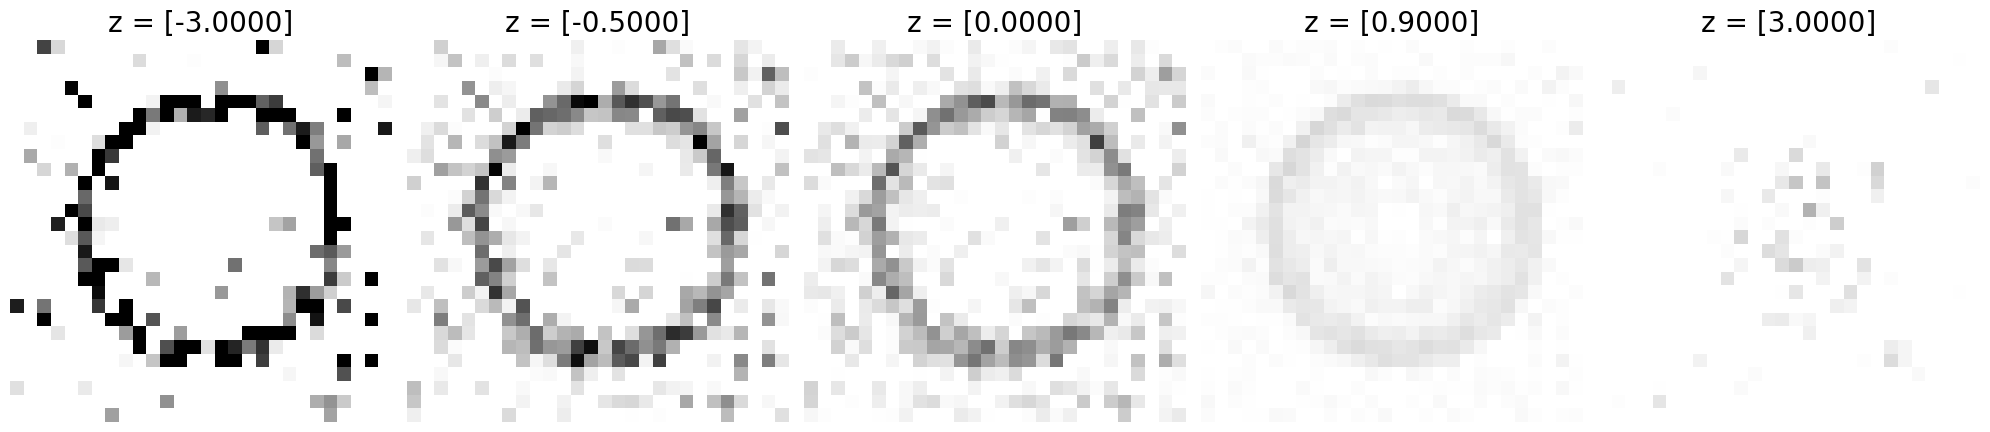

In [42]:
fig = figure4(model_ae, "cpu")

In [47]:
model_ae.encoder(circles_ds[0][0])

tensor([[1.2237]], grad_fn=<AddmmBackward0>)

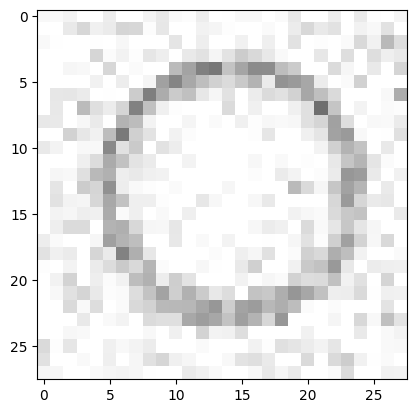

In [66]:
random_noise = torch.tensor([[0.23]])

kwargs = {'cmap': 'gray', 'vmin': 0, 'vmax': 1}
synthetic_image = model_ae.decoder(random_noise)[0][0].float().to("cpu").detach().numpy()
plt.imshow(synthetic_image, **kwargs)
plt.show()